In [2]:
from keras.datasets import cifar10
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [3]:
print(X_train.shape)
print(Y_train.shape)
# 50000 entries of dimen 32*32*3 
# y_train has 50000 labels

(50000, 32, 32, 3)
(50000, 1)


In [4]:
print(X_test.shape)
print(Y_test.shape)

(10000, 32, 32, 3)
(10000, 1)


In [5]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [6]:
Y_train
# all the images are labelled over 10 categories. 

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

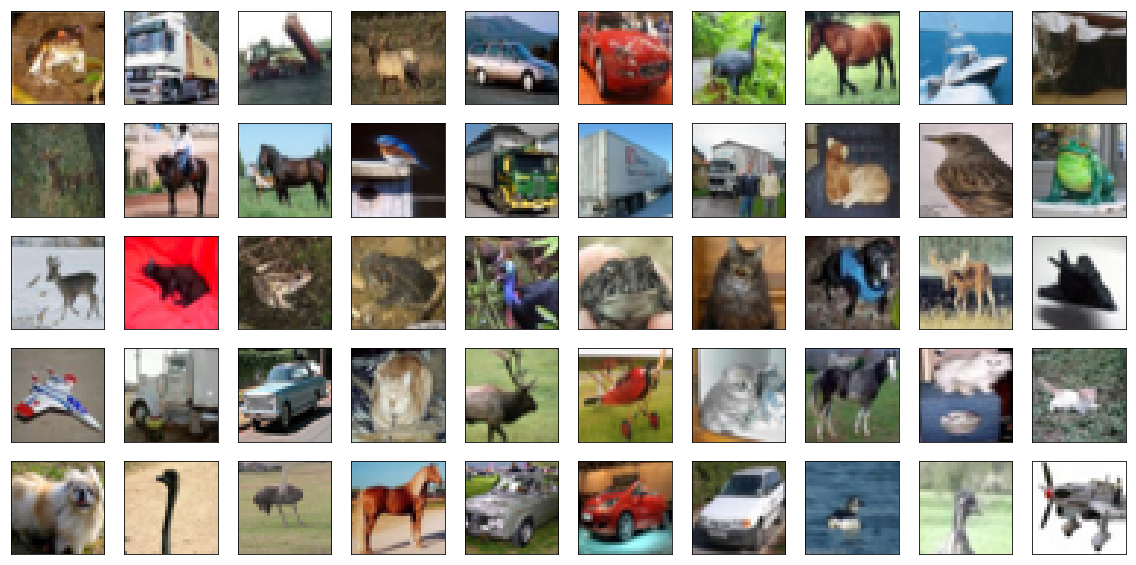

In [8]:
# visualize the first 50 images of training set
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,10))
for i in range(50):
    ax = fig.add_subplot(5,10,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

In [7]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Lambda
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

num_classes = 10
weight_decay = 1e-4

Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

model = Sequential()
model.add(Lambda(lambda x: x / 255, input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Increase training dataset by using data augmentation

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

# Training stage of the classification model

batch_size = 64

opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy', \
              optimizer=opt_rms, \
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', \
                              factor=0.2, \
                              patience=5, \
                              min_lr=0.0003)

model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), \
                    steps_per_epoch=X_train.shape[0] // batch_size, \
                    epochs=200, \
                    verbose=1, \
                    validation_data=(X_test, Y_test), \
                    callbacks=[reduce_lr])

# Serializing the model

model.save("../model3.h5")

# Evaluation stage

scores = model.evaluate(X_test, Y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1] * 100, scores[0]))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)      

In [9]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import load_model

if __name__ == '__main__':

    # Load the dataset
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

    model = load_model("../model.h5")
    scores = model.evaluate(X_test, to_categorical(Y_test))
    model.summary()

    print('Loss: %.3f' % scores[0])
    print('Accuracy: %.3f' % scores[1])



10000/10000 [==============================] - 66s 7ms/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
__________________________________________________________